# Forecast period vs. track position bias for the two models ECMWF and IITM

## bias = model minus observation, where observation is ERA5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import math

from collections import Counter
import json
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

import cartopy.crs as ccrs
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime
import traceback

import os

from netCDF4 import Dataset
import netCDF4
import copy

In [2]:
# currently using time since model genesis. NEED TO DECIDE whether we want to use this or time since observation
# genesis.

# Helper methods

In [3]:
# purpose: to return relevant lists to make a position bias plot. Includes all 102 systems (doesn't separate by depression/low)

def position_bias_plot_hourly_ALL(newLonFor, newLatFor, newLonObs, newLatObs):
    # below, 'list of distances' is defined for one time (i.e. an hour value between 0 and 240) such that it contains a list of the 
    # position biases [i.e. distances] of all 102 storms evaluated at that hour
    
    forecast_period_dist = [] # the x-axis values (i.e. 0, 6, 12, ..., 240) in hours
    track_position_bias_dist = [] # mean of the list of distances
    track_position_bias_90th = [] # 90th percentile of the list of distances
    track_position_bias_10th = [] # 10th percentile of the list of distances
    track_position_bias_median = [] # median of the list of distances
    track_std_dev = [] # standard deviation of the list of distances
    num_systems = [] # for each hour, keeps track of the number of systems that exist

    clock = 0
    a = 6371e3 # earth's radius in m
    for i in range(41):

        #include all 102 systems
        lon = np.subtract([arr[i] for arr in newLonFor if len(arr) > i], [arr[i] for arr in newLonObs if len(arr) > i])
        lat = np.subtract([arr[i] for arr in newLatFor if len(arr) > i], [arr[i] for arr in newLatObs if len(arr) > i])
        lat_avg = [(arrFor[i] + arrObs[i])/2 for arrFor, arrObs in zip(newLatFor, newLatObs) if len(arrFor) > i and len(arrObs) > i]

        forecast_period_dist.append(clock)

        dist_list = [math.sqrt((a*(x*math.pi/180)*math.cos(z*math.pi/180))**2 + (a*y*math.pi/180)**2) for x,y,z in zip(lon, lat, lat_avg) 
                     if abs(x) < 500 and abs(y) < 500]
        
        dist_list = [x/1000 for x in dist_list] # convert m to km

        num_systems.append(len(dist_list))
        track_position_bias_dist.append(np.mean(dist_list))
        track_position_bias_median.append(np.median(dist_list))
        track_position_bias_10th.append(np.percentile(dist_list, 10))
        track_position_bias_90th.append(np.percentile(dist_list, 90))
        track_std_dev.append(np.std(dist_list))

        clock += 6
        
    return [forecast_period_dist, track_position_bias_dist, track_position_bias_90th, 
            track_position_bias_10th, track_position_bias_median, track_std_dev, num_systems]


In [4]:
# purpose: to return relevant lists to make a position bias plot. separates by depressions and lows
# separates by observation depressions/lows instead of by model depressions/lows

def position_bias_plot_hourly_SEPARATE(newLonFor, newLatFor, newLonObs, newLatObs, depressionsOrLowsIndicesObs):
    forecast_period_dist = []
    track_position_bias_dist = [] # mean of the list of distances
    track_position_bias_90th = [] # 90th percentile of the list of distances
    track_position_bias_10th = [] # 10th percentile of the list of distances
    track_position_bias_median = [] # median of the list of distances
    track_std_dev = []
    num_systems = []

    clock = 0
    a = 6371e3 # earth's radius in m
    for i in range(41):

        #include only the depressions
        lon = np.subtract([arr[i] for arr in newLonFor if len(arr) > i and newLonFor.index(arr) in depressionsOrLowsIndicesObs], 
                          [arr[i] for arr in newLonObs if len(arr) > i and newLonObs.index(arr) in depressionsOrLowsIndicesObs])
        
        lat = np.subtract([arr[i] for arr in newLatFor if len(arr) > i and newLatFor.index(arr) in depressionsOrLowsIndicesObs], 
                          [arr[i] for arr in newLatObs if len(arr) > i and newLatObs.index(arr) in depressionsOrLowsIndicesObs])
        
        lat_avg = [(arrFor[i] + arrObs[i])/2 for arrFor, arrObs in zip(newLatFor, newLatObs) if len(arrFor) > i and len(arrObs) > i and 
                   newLatFor.index(arrFor) in depressionsOrLowsIndicesObs]

        dist_list = [math.sqrt((a*(x*math.pi/180)*math.cos(z*math.pi/180))**2 + (a*y*math.pi/180)**2) for x,y,z in zip(lon, lat, lat_avg) 
                     if abs(x) < 500 and abs(y) < 500] # cosine weighted distance formula from lat/lon coord.s, outputs km
        dist_list = [x/1000 for x in dist_list] # convert m to km
        
        if len(dist_list) == 0:
            clock += 6
            continue
            
        forecast_period_dist.append(clock)
        num_systems.append(len(dist_list))
        track_position_bias_dist.append(np.mean(dist_list))
        track_position_bias_90th.append(np.percentile(dist_list, 90))
        track_position_bias_10th.append(np.percentile(dist_list, 10))
        track_position_bias_median.append(np.median(dist_list))
        track_std_dev.append(np.std(dist_list))

        clock += 6
        
    return [forecast_period_dist, track_position_bias_dist, track_position_bias_90th, track_position_bias_10th, track_position_bias_median, 
            track_std_dev, num_systems]


In [5]:
# purpose: make the position bias plots but bin plots by day (so 1 dot represents 1 day)

def position_bias_plot_daily_ALL(dist_list_of_lists):
    day_forecast_period = []
    day_track_position_bias = []
    day_track_position_bias_90th = []
    day_track_position_bias_10th = []
    day_track_std_dev = []
    day_num_systems = []
    day_list_of_lists = []

    clock = 1
    for i in range(10):
        #need i = 0 to get day 1 i.e. indices 0, 1, 2, 3 in dist_list_of_lists
        #need i = 1 to get day 2 i.e. indices 4, 5, 6, 7
        x = i * 4
        needed_indices = [x,x+1,x+2,x+3]
        y = []
        for index in needed_indices:
            y += dist_list_of_lists[index]

        day_list_of_lists.append(y)
        day_forecast_period.append(clock)
        day_track_position_bias.append(np.mean(y))
        day_track_position_bias_10th.append(np.percentile(y, 10))
        day_track_position_bias_90th.append(np.percentile(y, 90))
        day_track_std_dev.append(np.std(y))

        clock += 1
        
    return [day_forecast_period, day_track_position_bias, day_track_position_bias_90th, day_track_position_bias_10th, day_track_std_dev, 
            day_num_systems, day_list_of_lists]



In [6]:
def plot_figure(forecast_period_dist, track_position_bias_dist, track_position_bias_90th_dist, track_position_bias_10th_dist,
                track_std_dev_dist, num_systems, dailyOrHourly, title, median = False):

    fig, ax = plt.subplots(figsize=(9,4.8))
    points = ax.scatter(forecast_period_dist, track_position_bias_dist, c=num_systems, cmap = 'copper_r')
    plt.colorbar(points).set_label('Number of Systems')
    
    if median != False:
        ax.plot(forecast_period_dist, median, '-')

    ax.errorbar(forecast_period_dist, track_position_bias_dist, yerr = track_std_dev_dist)
    ax.fill_between(forecast_period_dist, track_position_bias_10th_dist, track_position_bias_90th_dist, alpha=0.05)
    ax.set_ylim([0, 1600])
    #ax.set_xlim([0, 250])
    if dailyOrHourly == 'daily':
        ax.set_xticks(np.arange(1, 11, 1))
    elif dailyOrHourly == 'hourly':
        ax.set_xticks(np.arange(0, 251, 24))
    ax.grid()
    ax.set_xlabel("Forecast lead time (h)")
    ax.set_ylabel("Position bias (km)")
    ax.set_title(title)
    plt.show()

# Creating lists by 6-hour forecast period ECMWF

## Read files (ECMWF)

In [7]:
#with open("newScripts/Modified_newLonFor.txt", "r") as handle:        # aligned by model genesis
with open("newScripts/Obs_aligned_newLonFor.txt", "r") as handle:    # aligned by observation genesis
    newLonFor_ecmwf = json.load(handle)
    
#with open("newScripts/Modified_newLonObs.txt", "r") as handle:
with open("newScripts/Obs_aligned_newLonObs.txt", "r") as handle:
    newLonObs_ecmwf = json.load(handle)
    
#with open("newScripts/Modified_newLatFor.txt", "r") as handle:
with open("newScripts/Obs_aligned_newLatFor.txt", "r") as handle:
    newLatFor_ecmwf = json.load(handle)
    
#with open("newScripts/Modified_newLatObs.txt", "r") as handle:
with open("newScripts/Obs_aligned_newLatObs.txt", "r") as handle:
    newLatObs_ecmwf = json.load(handle)

In [8]:
with open("newScripts/Track_depressionsIndicesFor.txt", "r") as handle:
    depressionsIndicesFor_ecmwf = json.load(handle)
    
with open("newScripts/Track_depressionsIndicesObs.txt", "r") as handle:
    depressionsIndicesObs_ecmwf = json.load(handle)
    
with open("newScripts/Track_lowsIndicesFor.txt", "r") as handle:
    lowsIndicesFor_ecmwf = json.load(handle)
    
with open("newScripts/Track_lowsIndicesObs.txt", "r") as handle:
    lowsIndicesObs_ecmwf = json.load(handle)

In [9]:
print(len(depressionsIndicesFor_ecmwf), len(depressionsIndicesObs_ecmwf))

47 53


## Modify lists (ECMWF)

In [10]:
#need to mask because if Obs and For both have 9999 for a value then subtracting will give 0, so it'll look like there's
#0 bias when in fact we want to exclude this point.
newLonObs2_ecmwf = copy.deepcopy(newLonObs_ecmwf)
index = 0
for arr in newLonObs2_ecmwf:
    newLonObs2_ecmwf[index] = [x if x != 9999 else 19998 for x in arr]
    index += 1

In [11]:
newLatObs2_ecmwf = copy.deepcopy(newLatObs_ecmwf)
index = 0
for arr in newLatObs2_ecmwf:
    newLatObs2_ecmwf[index] = [x if x != 9999 else 19998 for x in arr]
    index += 1

In [12]:
np.subtract([len(arr) for arr in newLatFor_ecmwf], [len(arr) for arr in newLatObs2_ecmwf])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
for i in range(41):
    index = 0
    for arr in newLonObs2_ecmwf:
        if len(arr) > i and len(newLonFor_ecmwf[index]) <= i:
            print('oops')
        index += 1

## Make plots for lon and lat separately (ECMWF)

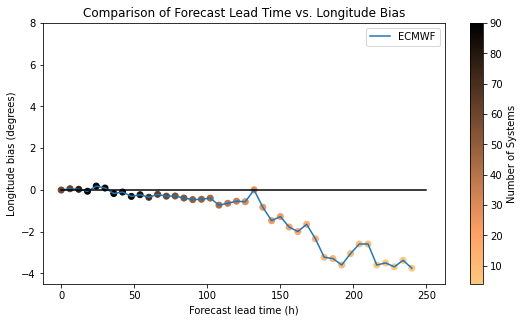

In [16]:
forecast_period_lon_ecmwf = []
track_position_bias_lon_ecmwf = []
num_systems_lon_ecmwf = []
clock = 0
for i in range(41):
    
    # here, not bothering to separate depression vs. lows because these figures are not going in the paper
    x = np.subtract([arr[i] for arr in newLonFor_ecmwf if len(arr) > i], [arr[i] for arr in newLonObs2_ecmwf if len(arr) > i])
    x = [elem for elem in x if abs(elem) < 500]
    
    forecast_period_lon_ecmwf.append(clock)
    num_systems_lon_ecmwf.append(len(x))
    bias = np.mean(x)
    if abs(bias) > 10:
        print(bias, i)
    track_position_bias_lon_ecmwf.append(bias)
    clock += 6

fig, ax = plt.subplots(figsize=(9,4.8))
points = ax.scatter(forecast_period_lon_ecmwf, track_position_bias_lon_ecmwf, c=num_systems_lon_ecmwf, cmap = 'copper_r')
plt.colorbar(points).set_label("Number of Systems")

plt.plot(forecast_period_lon_ecmwf, track_position_bias_lon_ecmwf, label = 'ECMWF')
plt.plot([0, 250], [0, 0], 'black')
plt.ylim(-4.5, 8)
ax.set_xlabel("Forecast lead time (h)")
ax.set_ylabel("Longitude bias (degrees)")
ax.set_title("Comparison of Forecast Lead Time vs. Longitude Bias")
ax.legend()

In [17]:
#change the range and these means will match the means from scatterLon exactly; they are taken by collapsing 2D list

check1D = []
for i in range(15, 41):
    x = np.subtract([arr[i] for arr in newLonObs2_ecmwf if len(arr) > i], [arr[i] for arr in newLonFor_ecmwf if len(arr) > i])
    #check1D.append(x)
    check1D.append([elem for elem in x if abs(elem) < 100])

np.mean([j for sub in check1D for j in sub])

1.173746659718882

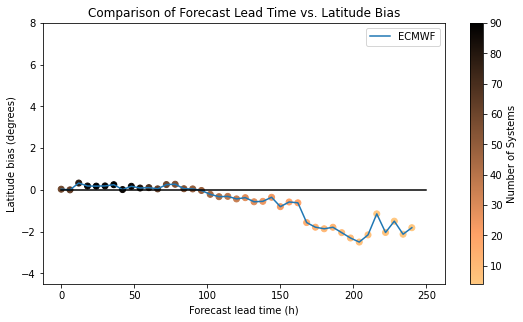

In [18]:
forecast_period_lat_ecmwf = []
track_position_bias_lat_ecmwf = []
num_systems_lat_ecmwf = []
clock = 0
for i in range(41):
    
    # here, not bothering to separate depression vs. lows because these figures are not going in the paper
    x = np.subtract([arr[i] for arr in newLatFor_ecmwf if len(arr) > i], [arr[i] for arr in newLatObs2_ecmwf if len(arr) > i])
    x = [elem for elem in x if abs(elem) < 500]
    
    forecast_period_lat_ecmwf.append(clock)
    num_systems_lat_ecmwf.append(len(x))
    bias = np.mean(x)
    if abs(bias) > 10:
        print(bias, i)
    track_position_bias_lat_ecmwf.append(bias)
    clock += 6
    
fig, ax = plt.subplots(figsize=(9,4.8))
points = ax.scatter(forecast_period_lat_ecmwf, track_position_bias_lat_ecmwf, c=num_systems_lat_ecmwf, cmap = 'copper_r')
plt.colorbar(points).set_label("Number of Systems")
    
#plt.plot(forecast_period_lat_ecmwf, track_position_bias_lat_ecmwf, 'bo')
plt.plot(forecast_period_lat_ecmwf, track_position_bias_lat_ecmwf, label = 'ECMWF')
plt.plot([0, 250], [0, 0], 'black')
plt.ylim([-4.5, 8])
ax.set_xlabel("Forecast lead time (h)")
ax.set_ylabel("Latitude bias (degrees)")
ax.set_title("Comparison of Forecast Lead Time vs. Latitude Bias")
ax.legend()

## Preparing lists to eventually test difference of means of ECMWF and IITM (Doing for ECMWF)

In [19]:
#prepare ECMWF list for testing whether ECMWF and IITM data are drawn from distributions with different means

dist_list_of_lists_ecmwf = []
oopsies = []
a = 6371e3
for i in range(41):    
    #include all 102 systems
    #lon = np.subtract([arr[i] for arr in newLonFor_ecmwf if len(arr) > i], [arr[i] for arr in newLonObs2_ecmwf if len(arr) > i])
    #lat = np.subtract([arr[i] for arr in newLatFor_ecmwf if len(arr) > i], [arr[i] for arr in newLatObs2_ecmwf if len(arr) > i])
    #lat_avg = [(arrFor[i] + arrObs[i])/2 for arrFor, arrObs in zip(newLatFor_ecmwf, newLatObs2_ecmwf) if len(arrFor) > i and len(arrObs) > i]
    
    #include only the depressions
    lon = np.subtract([arr[i] for arr in newLonFor_ecmwf if len(arr) > i and newLonFor_ecmwf.index(arr) in depressionsIndicesObs_ecmwf], [arr[i] for arr in newLonObs2_ecmwf if len(arr) > i and newLonObs2_ecmwf.index(arr) in depressionsIndicesObs_ecmwf])
    lat = np.subtract([arr[i] for arr in newLatFor_ecmwf if len(arr) > i and newLatFor_ecmwf.index(arr) in depressionsIndicesObs_ecmwf], [arr[i] for arr in newLatObs2_ecmwf if len(arr) > i and newLatObs2_ecmwf.index(arr) in depressionsIndicesObs_ecmwf])
    lat_avg = [(arrFor[i] + arrObs[i])/2 for arrFor, arrObs in zip(newLatFor_ecmwf, newLatObs2_ecmwf) if len(arrFor) > i and len(arrObs) > i and newLatFor_ecmwf.index(arrFor) in depressionsIndicesObs_ecmwf]

    
    #dist_list = [math.sqrt(x**2 + y**2) for x,y in zip(lon, lat) if abs(x) < 500 and abs(y) < 500]
    dist_list = [math.sqrt((a*(x*math.pi/180)*math.cos(z*math.pi/180))**2 + (a*y*math.pi/180)**2) for x,y,z in zip(lon, lat, lat_avg) if abs(x) < 500 and abs(y) < 500]
    dist_list = [x/1000 for x in dist_list]
    
    dist_list_of_lists_ecmwf.append(dist_list)
    oopsies.append(lon)

In [15]:
'''
demo cell for debugging; DO NOT RUN

model_lon is a double list of this format: [system_2007_06_07, system_2007_07_25, ..., system_2018_09_15], where
    system_yyyy_mm_dd = [20.5, 21.5, 19.5, ..., 17.5] i.e. a list of the lon coordinates for that system
    len(system_yyyy_mm_dd) = 41 because we have 10 day forecasts with a 6-hour temporal resolution
        (24*10 = 240 hours in the forecast; 240/6 = 40; 40 + 1 for hour 0 = 41 points)

So below when I do [arr[i] for arr in model_lon], I'm doing a list comprehension that takes the i-th element of each 
    sublist within model_lon. So if i = 0, I want elements corresponding to hour 0 across all the systems.
'''

forecast_period = []
track_position_bias = []
clock = 0
a = 6371e3 #earth's radius in meters
for i in range(41): #because there are 41 time points
    lon = np.subtract([arr[i] for arr in model_lon], [arr[i] for arr in observation_lon]) #lon bias
    lat = np.subtract([arr[i] for arr in model_lat], [arr[i] for arr in observation_lat]) #lat bias
    lat_avg = [(arr_model[i] + arr_obs[i])/2 for arr_model, arr_obs in zip(model_lat, observation_lat)]
    
    dist_list = [math.sqrt( (a*x*math.cos(z*math.pi/180))**2 + (a*y)**2 for x,y,z in zip(lon,lat,lat_avg) )]
    track_position_bias.append(np.mean(dist_list))
    
    forecast_period.append(clock)
    clock += 6
    

NameError: name 'model_lon' is not defined

## Make plots of position bias for ECMWF

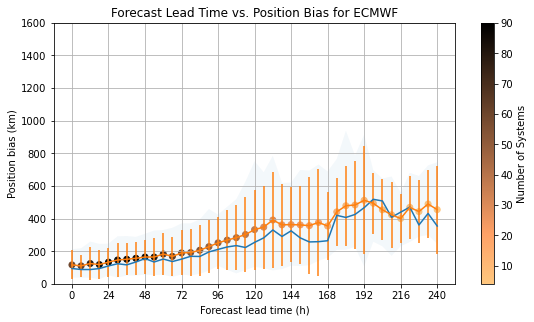

In [20]:
# plot all 102 systems, hourly

result = position_bias_plot_hourly_ALL(newLonFor_ecmwf, newLatFor_ecmwf, newLonObs2_ecmwf, newLatObs2_ecmwf)

forecast_period_ecmwf = result[0]
track_position_bias_mean_ecmwf = result[1]
track_position_bias_90th_ecmwf = result[2]
track_position_bias_10th_ecmwf = result[3]
track_position_bias_median_ecmwf = result[4]
track_position_bias_stddev_ecmwf = result[5]
num_systems_ecmwf = result[6]

plot_figure(forecast_period_ecmwf, track_position_bias_mean_ecmwf, track_position_bias_90th_ecmwf, 
            track_position_bias_10th_ecmwf, track_position_bias_stddev_ecmwf, num_systems_ecmwf, 
            'hourly', 'Forecast Lead Time vs. Position Bias for ECMWF', track_position_bias_median_ecmwf)

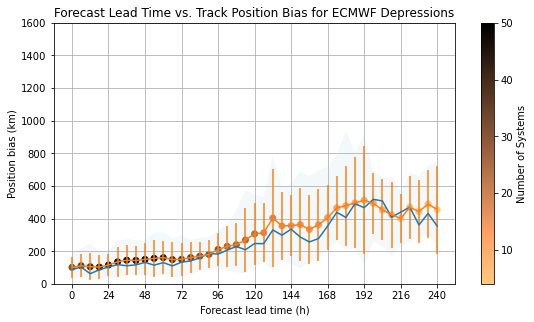

In [21]:
# plot only the depressions, hourly

result = position_bias_plot_hourly_SEPARATE(newLonFor_ecmwf, newLatFor_ecmwf, newLonObs2_ecmwf, newLatObs2_ecmwf, 
                                            depressionsIndicesObs_ecmwf)

forecast_period_ecmwf_D = result[0]
track_position_bias_mean_ecmwf_D = result[1]
track_position_bias_90th_ecmwf_D = result[2]
track_position_bias_10th_ecmwf_D = result[3]
track_position_bias_median_ecmwf_D = result[4]
track_position_bias_stddev_ecmwf_D = result[5]
num_systems_ecmwf_D = result[6]

plot_figure(forecast_period_ecmwf_D, track_position_bias_mean_ecmwf_D, track_position_bias_90th_ecmwf_D, 
            track_position_bias_10th_ecmwf_D, track_position_bias_stddev_ecmwf_D, num_systems_ecmwf_D, 
            'hourly', 'Forecast Lead Time vs. Track Position Bias for ECMWF Depressions', track_position_bias_median_ecmwf_D)

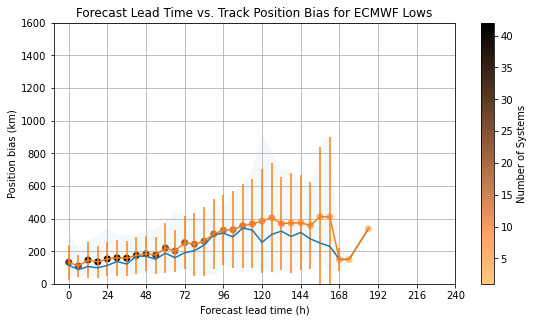

In [22]:
# plot only the lows, hourly

result = position_bias_plot_hourly_SEPARATE(newLonFor_ecmwf, newLatFor_ecmwf, newLonObs2_ecmwf, newLatObs2_ecmwf, 
                                            lowsIndicesObs_ecmwf)

forecast_period_ecmwf_L = result[0]
track_position_bias_mean_ecmwf_L = result[1]
track_position_bias_90th_ecmwf_L = result[2]
track_position_bias_10th_ecmwf_L = result[3]
track_position_bias_median_ecmwf_L = result[4]
track_position_bias_stddev_ecmwf_L = result[5]
num_systems_ecmwf_L = result[6]

plot_figure(forecast_period_ecmwf_L, track_position_bias_mean_ecmwf_L, track_position_bias_90th_ecmwf_L, 
            track_position_bias_10th_ecmwf_L, track_position_bias_stddev_ecmwf_L, num_systems_ecmwf_L, 
            'hourly', 'Forecast Lead Time vs. Track Position Bias for ECMWF Lows', track_position_bias_median_ecmwf_L)

# notes: no systems classified as 'lows' existed at hour 180 or after hour 186 (hence notice hour 180 is skipped).
# also, hours 174 and 186 had only one data point each (i.e. one system at those hours existed) so there are no error bars or 10th-90th fill area.

Text(0.5, 1.0, 'Forecast Lead Time vs. Position Bias in Days, ECMWF')

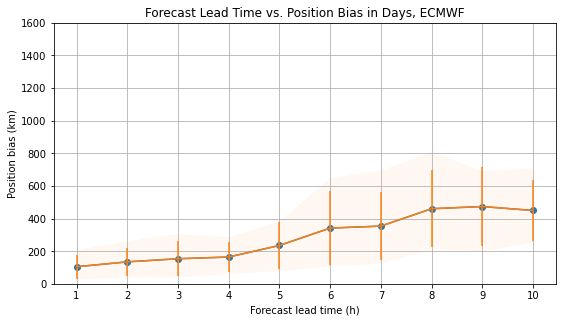

In [23]:
# plot all 102 systems, by the day

result = position_bias_plot_daily_ALL(dist_list_of_lists_ecmwf)

day_forecast_period_ecmwf = result[0]
day_track_position_bias_mean_ecmwf = result[1]
day_track_position_bias_90th_ecmwf = result[2]
day_track_position_bias_10th_ecmwf = result[3]
day_track_position_bias_stddev_ecmwf = result[4]
day_num_systems_ecmwf = result[5]
day_list_of_lists_ecmwf = result[6]

#plot_figure(day_forecast_period_ecmwf, day_track_position_bias_ecmwf, day_track_position_bias_90th_ecmwf, day_track_position_bias_10th_ecmwf,
  #         day_track_std_dev_ecmwf, day_num_systems_ecmwf, 'daily')

fig, ax = plt.subplots(figsize=(9,4.8))

ax.plot(day_forecast_period_ecmwf, day_track_position_bias_mean_ecmwf, '-')
ax.errorbar(day_forecast_period_ecmwf, day_track_position_bias_mean_ecmwf, yerr = day_track_position_bias_stddev_ecmwf)
ax.scatter(day_forecast_period_ecmwf, day_track_position_bias_mean_ecmwf)
ax.fill_between(day_forecast_period_ecmwf, day_track_position_bias_10th_ecmwf, day_track_position_bias_90th_ecmwf, 
                alpha=0.05)
ax.set_ylim([0, 1600])
#ax.set_xlim([1, 10])
ax.set_xticks(np.arange(1, 11, 1))
ax.grid()
ax.set_xlabel('Forecast lead time (h)')
ax.set_ylabel('Position bias (km)')
ax.set_title('Forecast Lead Time vs. Position Bias in Days, ECMWF')


# creating arrays by 6 hour forecast period IITM

## Reading files (IITM)

In [24]:
#with open("newScripts/ModifiedIITM_newLonFor.txt", "r") as handle:
with open("newScripts/Obs_alignedIITM_newLonFor.txt", "r") as handle:
    newLonFor_iitm = json.load(handle)
    
#with open("newScripts/ModifiedIITM_newLatFor.txt", "r") as handle:
with open("newScripts/Obs_alignedIITM_newLatFor.txt", "r") as handle:
    newLatFor_iitm = json.load(handle)
    
#with open("newScripts/ModifiedIITM_newLonObs.txt", "r") as handle:
with open("newScripts/Obs_alignedIITM_newLonObs.txt", "r") as handle:
    newLonObs_iitm = json.load(handle)
    
#with open("newScripts/ModifiedIITM_newLatObs.txt", "r") as handle:
with open("newScripts/Obs_alignedIITM_newLatObs.txt", "r") as handle:
    newLatObs_iitm = json.load(handle)

In [25]:
with open("newScripts/TrackIITM_depressionsIndicesFor.txt", "r") as handle:
    depressionsIndicesFor_iitm = json.load(handle)
    
with open("newScripts/TrackIITM_depressionsIndicesObs.txt", "r") as handle:
    depressionsIndicesObs_iitm = json.load(handle)
    
with open("newScripts/TrackIITM_lowsIndicesFor.txt", "r") as handle:
    lowsIndicesFor_iitm = json.load(handle)
    
with open("newScripts/TrackIITM_lowsIndicesObs.txt", "r") as handle:
    lowsIndicesObs_iitm = json.load(handle)

In [26]:
print(len(depressionsIndicesFor_iitm), len(lowsIndicesFor_iitm), len(depressionsIndicesObs_iitm), len(lowsIndicesObs_iitm))

25 77 53 49


In [27]:
print(len(newLonFor_iitm[0]))
print(len(newLonObs_iitm[0]))

41
41


## Modifying lists (IITM)

In [28]:
#need to mask because if Obs and For both have 9999 for a value then subtracting will give 0, so it'll look like there's
#0 bias when in fact we want to exclude this point.
newLonObs2_iitm = copy.deepcopy(newLonObs_iitm)
index = 0
for arr in newLonObs2_iitm:
    newLonObs2_iitm[index] = [x if x != 9999 else 19998 for x in arr]
    index += 1

In [29]:
#need to mask because if Obs and For both have 9999 for a value then subtracting will give 0, so it'll look like there's
#0 bias when in fact we want to exclude this point.
newLatObs2_iitm = copy.deepcopy(newLatObs_iitm)
index = 0
for arr in newLatObs2_iitm:
    newLatObs2_iitm[index] = [x if x != 9999 else 19998 for x in arr]
    index += 1

## Make plots for lon and lat separately (IITM)

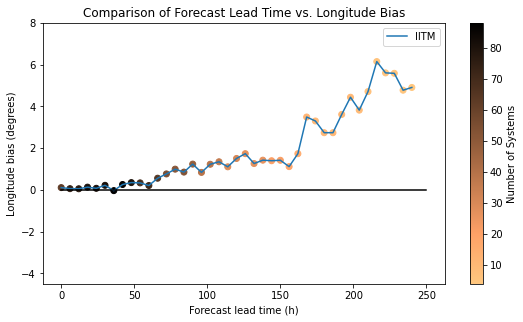

In [31]:
forecast_period_lon_iitm = []
track_position_bias_lon_iitm = []
num_systems_lon_iitm = []

clock = 0
for i in range(41):
    
    x = np.subtract([arr[i] for arr in newLonFor_iitm if len(arr) > i], [arr[i] for arr in newLonObs2_iitm if len(arr) > i])
    x = [elem for elem in x if abs(elem) < 500]
    
    forecast_period_lon_iitm.append(clock)
    
    num_systems_lon_iitm.append(len(x))
    bias = np.mean(x)
    if abs(bias) > 10:
        print(bias, i)
    track_position_bias_lon_iitm.append(bias)
    clock += 6
    
fig, ax = plt.subplots(figsize=(9,4.8))
points = ax.scatter(forecast_period_lon_iitm, track_position_bias_lon_iitm, c=num_systems_lon_iitm, cmap = 'copper_r')
plt.colorbar(points).set_label('Number of Systems')
    
#plt.plot(forecast_period_lon_iitm, track_position_bias_lon_iitm, 'bo')
plt.plot(forecast_period_lon_iitm, track_position_bias_lon_iitm, label = 'IITM')
plt.ylim(-4.5, 8)
plt.plot([0,250], [0,0], 'black')
ax.set_xlabel("Forecast lead time (h)")
ax.set_ylabel("Longitude bias (degrees)")
ax.set_title("Comparison of Forecast Lead Time vs. Longitude Bias")
ax.legend()

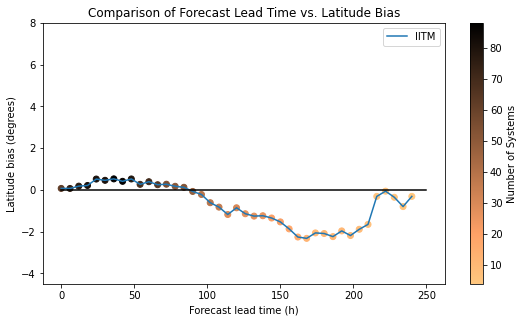

In [32]:
forecast_period_lat_iitm = []
track_position_bias_lat_iitm = []
num_systems_lat_iitm = []

clock = 0
for i in range(41):
    
    x = np.subtract([arr[i] for arr in newLatFor_iitm if len(arr) > i], [arr[i] for arr in newLatObs2_iitm if len(arr) > i])
    x = [elem for elem in x if abs(elem) < 500]
    
    forecast_period_lat_iitm.append(clock)
    num_systems_lat_iitm.append(len(x))
    bias = np.mean(x)
    if abs(bias) > 10:
        print(bias, i)
    track_position_bias_lat_iitm.append(bias)
    clock += 6
    
fig, ax = plt.subplots(figsize=(9,4.8))
points = ax.scatter(forecast_period_lat_iitm, track_position_bias_lat_iitm, c=num_systems_lat_iitm, cmap = 'copper_r')
plt.colorbar(points).set_label('Number of Systems')
    
#plt.plot(forecast_period_lat_iitm, track_position_bias_lat_iitm, 'bo')
plt.plot(forecast_period_lat_iitm, track_position_bias_lat_iitm, label = 'IITM')
plt.ylim([-4.5, 8])
plt.plot([0, 250], [0, 0], 'black')
ax.set_xlabel("Forecast lead time (h)")
ax.set_ylabel("Latitude bias (degrees)")
ax.set_title("Comparison of Forecast Lead Time vs. Latitude Bias")
ax.legend()

## Preparing lists to eventually test difference of means of ECMWF and IITM (Doing for IITM)

In [33]:
#prepare IITM list for testing whether ECMWF and IITM data are drawn from distributions with different means

dist_list_of_lists_iitm = []
for i in range(41):
    lon = np.subtract([arr[i] for arr in newLonFor_iitm if len(arr) > i], [arr[i] for arr in newLonObs2_iitm if len(arr) > i])
    lat = np.subtract([arr[i] for arr in newLatFor_iitm if len(arr) > i], [arr[i] for arr in newLatObs2_iitm if len(arr) > i])
    lat_avg = [(arrFor[i] + arrObs[i])/2 for arrFor, arrObs in zip(newLatFor_iitm, newLatObs2_iitm) if len(arrFor) > i and len(arrObs) > i]
    
    #dist_list = [math.sqrt(x**2 + y**2) for x,y in zip(lon, lat) if abs(x) < 500 and abs(y) < 500]
    dist_list = [math.sqrt((a*(x*math.pi/180)*math.cos(z*math.pi/180))**2 + (a*y*math.pi/180)**2) for x,y,z in zip(lon, lat, lat_avg) 
                 if abs(x) < 500 and abs(y) < 500]
    dist_list = [x/1000 for x in dist_list]
    
    dist_list_of_lists_iitm.append(dist_list)

## Make plots of position bias for IITM

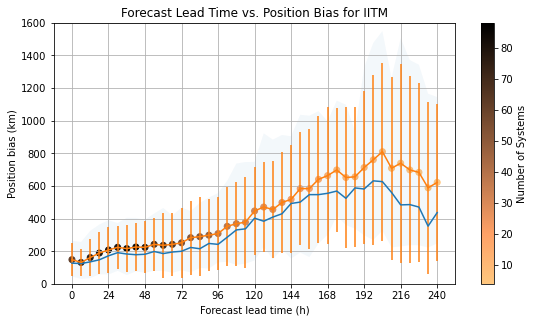

In [34]:
result = position_bias_plot_hourly_ALL(newLonFor_iitm, newLatFor_iitm, newLonObs2_iitm, newLatObs2_iitm)

forecast_period_iitm = result[0]
track_position_bias_mean_iitm = result[1]
track_position_bias_90th_iitm = result[2]
track_position_bias_10th_iitm = result[3]
track_position_bias_median_iitm = result[4]
track_position_bias_stddev_iitm = result[5]
num_systems_iitm = result[6]

plot_figure(forecast_period_iitm, track_position_bias_mean_iitm, track_position_bias_90th_iitm, 
            track_position_bias_10th_iitm, track_position_bias_stddev_iitm, num_systems_iitm, 
            'hourly', 'Forecast Lead Time vs. Position Bias for IITM', track_position_bias_median_iitm)

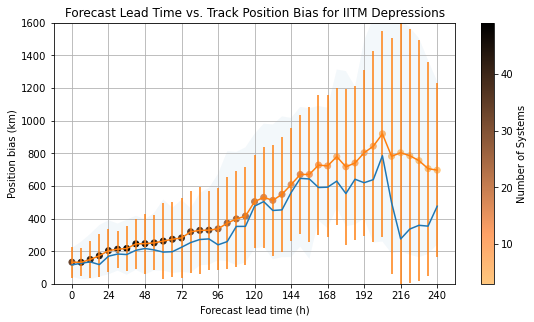

In [35]:
# plot only the depressions, hourly

result = position_bias_plot_hourly_SEPARATE(newLonFor_iitm, newLatFor_iitm, newLonObs2_iitm, newLatObs2_iitm, 
                                            depressionsIndicesObs_iitm)

forecast_period_iitm_D = result[0]
track_position_bias_mean_iitm_D = result[1]
track_position_bias_90th_iitm_D = result[2]
track_position_bias_10th_iitm_D = result[3]
track_position_bias_median_iitm_D = result[4]
track_position_bias_stddev_iitm_D = result[5]
num_systems_iitm_D = result[6]

plot_figure(forecast_period_iitm_D, track_position_bias_mean_iitm_D, track_position_bias_90th_iitm_D, 
            track_position_bias_10th_iitm_D, track_position_bias_stddev_iitm_D, num_systems_iitm_D, 
            'hourly', 'Forecast Lead Time vs. Track Position Bias for IITM Depressions', track_position_bias_median_iitm_D)

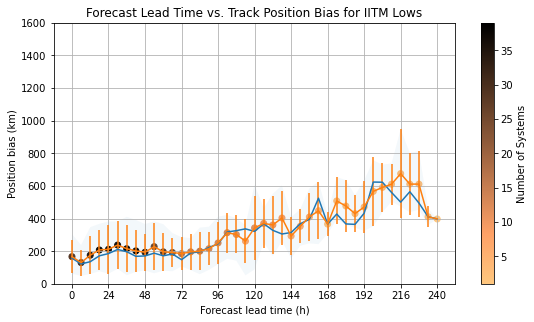

In [36]:
# plot only the lows, hourly

result = position_bias_plot_hourly_SEPARATE(newLonFor_iitm, newLatFor_iitm, newLonObs2_iitm, newLatObs2_iitm, 
                                            lowsIndicesObs_iitm)

forecast_period_iitm_L = result[0]
track_position_bias_mean_iitm_L = result[1]
track_position_bias_90th_iitm_L = result[2]
track_position_bias_10th_iitm_L = result[3]
track_position_bias_median_iitm_L = result[4]
track_position_bias_stddev_iitm_L = result[5]
num_systems_iitm_L = result[6]

plot_figure(forecast_period_iitm_L, track_position_bias_mean_iitm_L, track_position_bias_90th_iitm_L, 
            track_position_bias_10th_iitm_L, track_position_bias_stddev_iitm_L, num_systems_iitm_L, 
            'hourly', 'Forecast Lead Time vs. Track Position Bias for IITM Lows', track_position_bias_median_iitm_L)

Text(0.5, 1.0, 'Forecast Lead Time vs. Position Bias in Days, IITM')

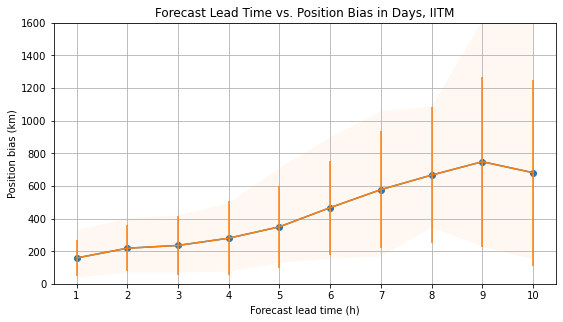

In [38]:
# plot all 102 systems, by the day

result = position_bias_plot_daily_ALL(dist_list_of_lists_iitm)

day_forecast_period_iitm = result[0]
day_track_position_bias_mean_iitm = result[1]
day_track_position_bias_90th_iitm = result[2]
day_track_position_bias_10th_iitm = result[3]
day_track_position_bias_stddev_iitm = result[4]
day_num_systems_iitm = result[5]
day_list_of_lists_iitm = result[6]

#plot_figure(day_forecast_period_ecmwf, day_track_position_bias_ecmwf, day_track_position_bias_90th_ecmwf, 
  #          day_track_position_bias_10th_ecmwf, day_track_std_dev_ecmwf, day_num_systems_ecmwf, 'daily')

fig, ax = plt.subplots(figsize=(9,4.8))

ax.plot(day_forecast_period_iitm, day_track_position_bias_mean_iitm, '-')
ax.errorbar(day_forecast_period_iitm, day_track_position_bias_mean_iitm, yerr = day_track_position_bias_stddev_iitm)
ax.scatter(day_forecast_period_iitm, day_track_position_bias_mean_iitm)
ax.fill_between(day_forecast_period_iitm, day_track_position_bias_10th_iitm, day_track_position_bias_90th_iitm, alpha=0.05)
ax.set_ylim([0, 1600])
#ax.set_xlim([1, 10])
ax.set_xticks(np.arange(1, 11, 1))
ax.grid()
ax.set_xlabel('Forecast lead time (h)')
ax.set_ylabel('Position bias (km)')
ax.set_title('Forecast Lead Time vs. Position Bias in Days, IITM')


# Comparison

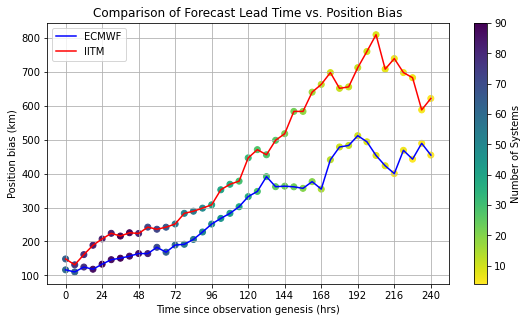

In [39]:
# compare the mean track position bias by hour (for  all 102 systems)

fig, ax = plt.subplots(figsize=(9,4.8))
points_ecmwf = ax.scatter(forecast_period_ecmwf, track_position_bias_mean_ecmwf, c=num_systems_ecmwf, cmap = 'viridis_r')
plt.colorbar(points_ecmwf).set_label("Number of Systems")
plt.plot(forecast_period_ecmwf, track_position_bias_mean_ecmwf, 'b', label = 'ECMWF')

points_iitm = ax.scatter(forecast_period_iitm, track_position_bias_mean_iitm, c=num_systems_iitm, cmap = 'viridis_r')
plt.plot(forecast_period_iitm, track_position_bias_mean_iitm, 'r', label = 'IITM')
#ax.set_facecolor('grey')

ax.set_xticks(np.arange(0, 250, 24))
ax.grid()
ax.set_xlabel("Time since observation genesis (hrs)")
ax.set_ylabel("Position bias (km)")
ax.set_title("Comparison of Forecast Lead Time vs. Position Bias")
ax.legend()

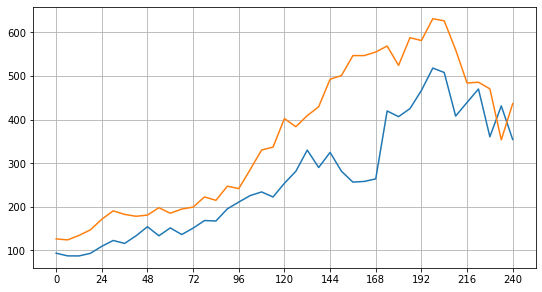

In [40]:
#compare the median track position bias by hour (for  all 102 systems)

fig, ax = plt.subplots(figsize=(9,4.8))
ax.plot(forecast_period_ecmwf, track_position_bias_median_ecmwf, '-')
ax.plot(forecast_period_iitm, track_position_bias_median_iitm, '-')

ax.set_xticks(np.arange(0, 250, 24))
ax.grid()

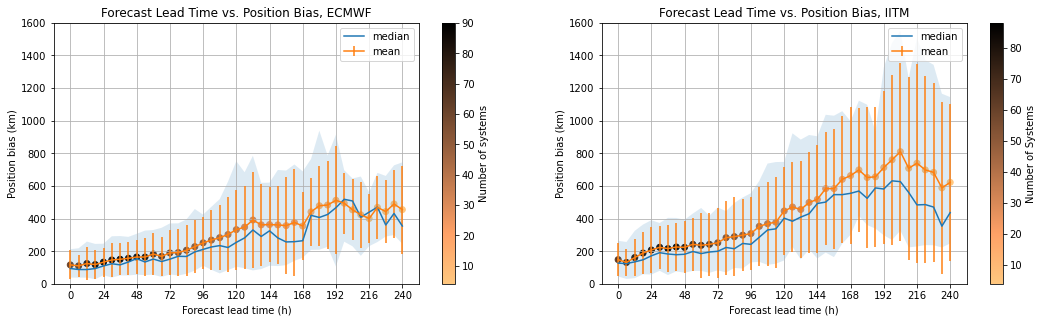

In [51]:
#compare IITM and ECMWF side by side for: mean, median, stddev and 10th-90th fill (for  all 102 systems)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4.8))

points = ax1.scatter(forecast_period_ecmwf, track_position_bias_mean_ecmwf, c=num_systems_ecmwf, cmap = 'copper_r')
plt.colorbar(points, ax=ax1).set_label('Number of systems')
ax1.plot(forecast_period_ecmwf, track_position_bias_median_ecmwf, '-', label='median')
ax1.errorbar(forecast_period_ecmwf, track_position_bias_mean_ecmwf, yerr = track_position_bias_stddev_ecmwf, label='mean')
ax1.fill_between(forecast_period_ecmwf, track_position_bias_10th_ecmwf, track_position_bias_90th_ecmwf, alpha=0.15)
ax1.set_ylim([0, 1600])
ax1.set_xticks(np.arange(0, 250, 24))
ax1.grid()
ax1.set_xlabel("Forecast lead time (h)")
ax1.set_ylabel("Position bias (km)")
ax1.set_title("Forecast Lead Time vs. Position Bias, ECMWF")
ax1.legend()


points2 = ax2.scatter(forecast_period_iitm, track_position_bias_mean_iitm, c=num_systems_iitm, cmap = 'copper_r')
plt.colorbar(points2, ax=ax2).set_label('Number of Systems')
ax2.plot(forecast_period_iitm, track_position_bias_median_iitm, '-', label='median')
ax2.errorbar(forecast_period_iitm, track_position_bias_mean_iitm, yerr = track_position_bias_stddev_iitm, label='mean')
ax2.fill_between(forecast_period_iitm, track_position_bias_10th_iitm, track_position_bias_90th_iitm, alpha=0.15)
ax2.set_ylim([0, 1600])
ax2.set_xticks(np.arange(0, 250, 24))
ax2.grid()
ax2.set_xlabel("Forecast lead time (h)")
ax2.set_ylabel("Position bias (km)")
ax2.set_title("Forecast Lead Time vs. Position Bias, IITM")
ax2.legend()


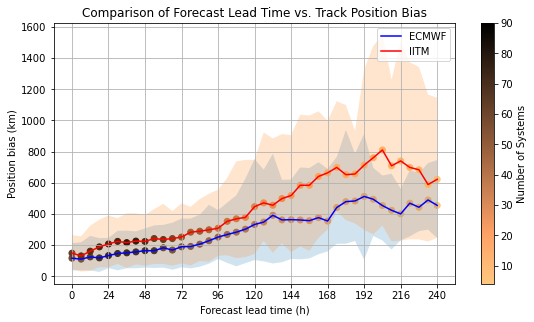

In [50]:
#comare mean and 10th-90th fill (for all 102 systems)

fig, ax = plt.subplots(figsize=(9,4.8))
points_ecmwf = ax.scatter(forecast_period_ecmwf, track_position_bias_mean_ecmwf, c=num_systems_ecmwf, cmap = 'copper_r')
plt.colorbar(points_ecmwf).set_label("Number of Systems")
plt.plot(forecast_period_ecmwf, track_position_bias_mean_ecmwf, 'b', label = 'ECMWF')
ax.fill_between(forecast_period_ecmwf, track_position_bias_10th_ecmwf, track_position_bias_90th_ecmwf, alpha=0.2)
#ax.plot(forecast_period_dist_ecmwf, median_ecmwf, '-', label='median ECMWF')

points_iitm = ax.scatter(forecast_period_iitm, track_position_bias_mean_iitm, c=num_systems_iitm, cmap = 'copper_r')
plt.plot(forecast_period_iitm, track_position_bias_mean_iitm, 'r', label = 'IITM')
ax.fill_between(forecast_period_iitm, track_position_bias_10th_iitm, track_position_bias_90th_iitm, alpha=0.2)
#ax.plot(forecast_period_dist_iitm, median_iitm, '-', label='median IITM')


ax.set_xticks(np.arange(0, 250, 24))
ax.grid()
ax.set_xlabel("Forecast lead time (h)")
ax.set_ylabel("Position bias (km)")
ax.set_title("Comparison of Forecast Lead Time vs. Track Position Bias")
ax.legend()

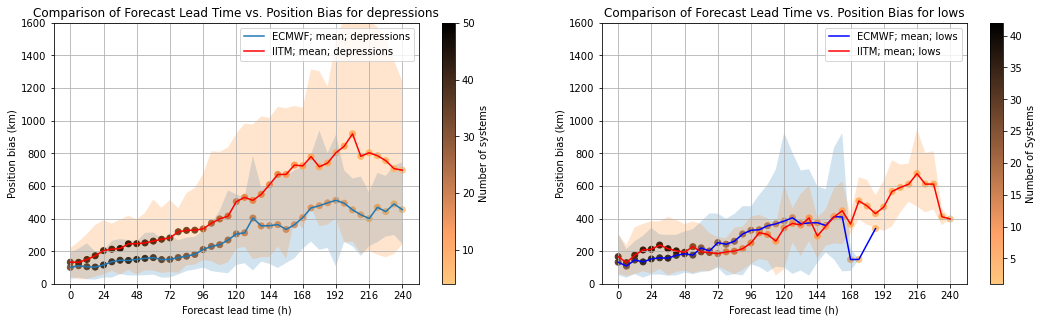

In [49]:
#compare depressions & lows side by side for mean and 10th-90th fill

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4.8))

points_ecmwf_D = ax1.scatter(forecast_period_ecmwf_D, track_position_bias_mean_ecmwf_D, c=num_systems_ecmwf_D, 
                             cmap = 'copper_r')
plt.colorbar(points_ecmwf_D, ax=ax1).set_label('Number of systems')
ax1.plot(forecast_period_ecmwf_D, track_position_bias_mean_ecmwf_D, '-', label='ECMWF; mean; depressions')
ax1.fill_between(forecast_period_ecmwf_D, track_position_bias_10th_ecmwf_D, track_position_bias_90th_ecmwf_D, alpha=0.2)

points_iitm_D = ax1.scatter(forecast_period_iitm_D, track_position_bias_mean_iitm_D, c=num_systems_iitm_D, 
                            cmap = 'copper_r')
ax1.plot(forecast_period_iitm_D, track_position_bias_mean_iitm_D, 'r', label = 'IITM; mean; depressions')
ax1.fill_between(forecast_period_iitm_D, track_position_bias_10th_iitm_D, track_position_bias_90th_iitm_D, alpha=0.2)

ax1.set_xticks(np.arange(0, 250, 24))
ax1.set_ylim([0, 1600])
ax1.grid()
ax1.set_xlabel("Forecast lead time (h)")
ax1.set_ylabel("Position bias (km)")
ax1.set_title("Comparison of Forecast Lead Time vs. Position Bias for depressions")
ax1.legend()


points_ecmwf_L = ax2.scatter(forecast_period_ecmwf_L, track_position_bias_mean_ecmwf_L, c=num_systems_ecmwf_L, 
                             cmap = 'copper_r')
plt.colorbar(points_ecmwf_L, ax=ax2).set_label('Number of Systems')
ax2.plot(forecast_period_ecmwf_L, track_position_bias_mean_ecmwf_L, 'b', label = 'ECMWF; mean; lows')
ax2.fill_between(forecast_period_ecmwf_L, track_position_bias_10th_ecmwf_L, track_position_bias_90th_ecmwf_L, alpha=0.2)

points_iitm_L = ax2.scatter(forecast_period_iitm_L, track_position_bias_mean_iitm_L, c=num_systems_iitm_L, 
                            cmap = 'copper_r')
ax2.plot(forecast_period_iitm_L, track_position_bias_mean_iitm_L, 'r', label = 'IITM; mean; lows')
ax2.fill_between(forecast_period_iitm_L, track_position_bias_10th_iitm_L, track_position_bias_90th_iitm_L, alpha=0.2)

ax2.set_xticks(np.arange(0, 250, 24))
ax2.set_ylim([0, 1600])
ax2.grid()
ax2.set_xlabel("Forecast lead time (h)")
ax2.set_ylabel("Position bias (km)")
ax2.set_title("Comparison of Forecast Lead Time vs. Position Bias for lows")
ax2.legend()

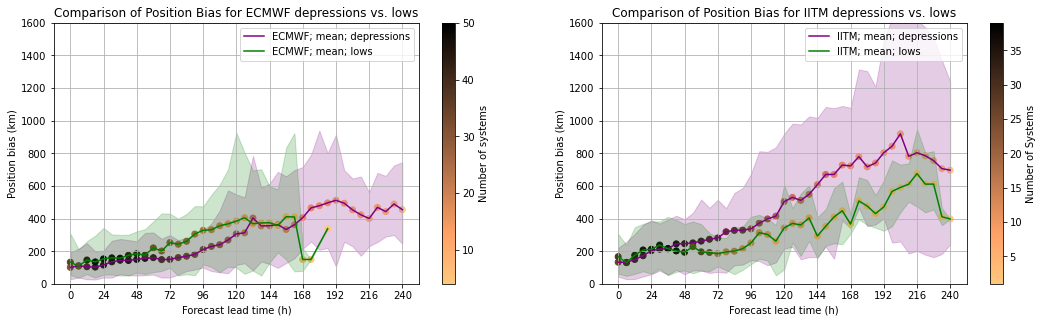

In [48]:
# compare depression vs low for ECMWF on the left, and for IITM on the right

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4.8))

points_ecmwf_D = ax1.scatter(forecast_period_ecmwf_D, track_position_bias_mean_ecmwf_D, 
                             c=num_systems_ecmwf_D, cmap = 'copper_r')
plt.colorbar(points_ecmwf_D, ax=ax1).set_label('Number of systems')
ax1.plot(forecast_period_ecmwf_D, track_position_bias_mean_ecmwf_D, color='purple', 
         label='ECMWF; mean; depressions')
ax1.fill_between(forecast_period_ecmwf_D, track_position_bias_10th_ecmwf_D, 
                 track_position_bias_90th_ecmwf_D, color='purple', alpha=0.2)

points_ecmwf_L = ax1.scatter(forecast_period_ecmwf_L, track_position_bias_mean_ecmwf_L, 
                             c=num_systems_ecmwf_L, cmap = 'copper_r')
ax1.plot(forecast_period_ecmwf_L, track_position_bias_mean_ecmwf_L, color='green', 
         label = 'ECMWF; mean; lows')
ax1.fill_between(forecast_period_ecmwf_L, track_position_bias_10th_ecmwf_L, 
                 track_position_bias_90th_ecmwf_L, color='green', alpha=0.2)

ax1.set_xticks(np.arange(0, 250, 24))
ax1.set_ylim([0, 1600])
ax1.grid()
ax1.set_xlabel("Forecast lead time (h)")
ax1.set_ylabel("Position bias (km)")
ax1.set_title("Comparison of Position Bias for ECMWF depressions vs. lows")
ax1.legend()


points_iitm_D = ax2.scatter(forecast_period_iitm_D, track_position_bias_mean_iitm_D, c=num_systems_iitm_D, 
                            cmap = 'copper_r')
ax2.plot(forecast_period_iitm_D, track_position_bias_mean_iitm_D, color='purple', label = 'IITM; mean; depressions')
ax2.fill_between(forecast_period_iitm_D, track_position_bias_10th_iitm_D, track_position_bias_90th_iitm_D, 
                 color='purple', alpha=0.2)

points_iitm_L = ax2.scatter(forecast_period_iitm_L, track_position_bias_mean_iitm_L, c=num_systems_iitm_L, 
                            cmap = 'copper_r')
ax2.plot(forecast_period_iitm_L, track_position_bias_mean_iitm_L, color='green', 
         label = 'IITM; mean; lows')
ax2.fill_between(forecast_period_iitm_L, track_position_bias_10th_iitm_L, 
                 track_position_bias_90th_iitm_L, color='green', alpha=0.2)
plt.colorbar(points_iitm_L, ax=ax2).set_label('Number of Systems')

ax2.set_xticks(np.arange(0, 250, 24))
ax2.set_ylim([0, 1600])
ax2.grid()
ax2.set_xlabel("Forecast lead time (h)")
ax2.set_ylabel("Position bias (km)")
ax2.set_title("Comparison of Position Bias for IITM depressions vs. lows")
ax2.legend()

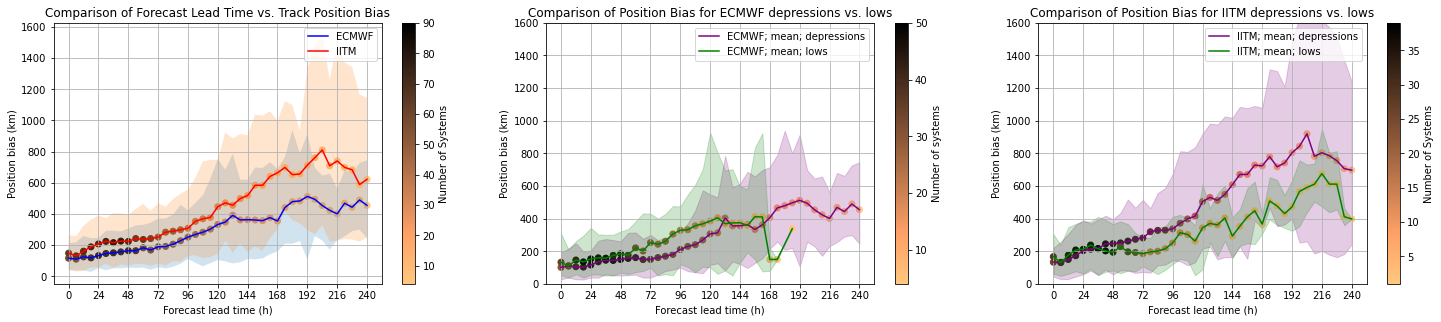

In [46]:
# 3-panel figure of ECMWF vs. IITM overall, ECMWF depressions vs. lows, IITM depressions vs. lows

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,4.8))

# ECMWF vs. IITM

points_ecmwf = ax1.scatter(forecast_period_ecmwf, track_position_bias_mean_ecmwf, c=num_systems_ecmwf, cmap = 'copper_r')
plt.colorbar(points_ecmwf, ax=ax1).set_label("Number of Systems")
ax1.plot(forecast_period_ecmwf, track_position_bias_mean_ecmwf, 'b', label = 'ECMWF')
ax1.fill_between(forecast_period_ecmwf, track_position_bias_10th_ecmwf, track_position_bias_90th_ecmwf, alpha=0.2)

points_iitm = ax1.scatter(forecast_period_iitm, track_position_bias_mean_iitm, c=num_systems_iitm, cmap = 'copper_r')
ax1.plot(forecast_period_iitm, track_position_bias_mean_iitm, 'r', label = 'IITM')
ax1.fill_between(forecast_period_iitm, track_position_bias_10th_iitm, track_position_bias_90th_iitm, alpha=0.2)

ax1.set_xticks(np.arange(0, 250, 24))
ax1.grid()
ax1.set_xlabel("Forecast lead time (h)")
ax1.set_ylabel("Position bias (km)")
ax1.set_title("Comparison of Forecast Lead Time vs. Track Position Bias")
ax1.legend()

# ECMWF depressions vs. lows

points_ecmwf_D = ax2.scatter(forecast_period_ecmwf_D, track_position_bias_mean_ecmwf_D, c=num_systems_ecmwf_D, 
                             cmap = 'copper_r')
plt.colorbar(points_ecmwf_D, ax=ax2).set_label('Number of systems')
ax2.plot(forecast_period_ecmwf_D, track_position_bias_mean_ecmwf_D, color='purple', 
         label='ECMWF; mean; depressions')
ax2.fill_between(forecast_period_ecmwf_D, track_position_bias_10th_ecmwf_D, 
                 track_position_bias_90th_ecmwf_D, color='purple', alpha=0.2)

points_ecmwf_L = ax2.scatter(forecast_period_ecmwf_L, track_position_bias_mean_ecmwf_L, c=num_systems_ecmwf_L, 
                             cmap = 'copper_r')
ax2.plot(forecast_period_ecmwf_L, track_position_bias_mean_ecmwf_L, color='green', 
         label = 'ECMWF; mean; lows')
ax2.fill_between(forecast_period_ecmwf_L, track_position_bias_10th_ecmwf_L, 
                 track_position_bias_90th_ecmwf_L, color='green', alpha=0.2)

ax2.set_xticks(np.arange(0, 250, 24))
ax2.set_ylim([0, 1600])
ax2.grid()
ax2.set_xlabel("Forecast lead time (h)")
ax2.set_ylabel("Position bias (km)")
ax2.set_title("Comparison of Position Bias for ECMWF depressions vs. lows")
ax2.legend()

# IITM depressions vs. lows

points_iitm_D = ax3.scatter(forecast_period_iitm_D, track_position_bias_mean_iitm_D, c=num_systems_iitm_D, 
                            cmap = 'copper_r')
ax3.plot(forecast_period_iitm_D, track_position_bias_mean_iitm_D, color='purple', 
         label = 'IITM; mean; depressions')
ax3.fill_between(forecast_period_iitm_D, track_position_bias_10th_iitm_D, 
                 track_position_bias_90th_iitm_D, color='purple', alpha=0.2)

points_iitm_L = ax3.scatter(forecast_period_iitm_L, track_position_bias_mean_iitm_L, c=num_systems_iitm_L, 
                            cmap = 'copper_r')
ax3.plot(forecast_period_iitm_L, track_position_bias_mean_iitm_L, color='green', 
         label = 'IITM; mean; lows')
ax3.fill_between(forecast_period_iitm_L, track_position_bias_10th_iitm_L, 
                 track_position_bias_90th_iitm_L, color='green', alpha=0.2)
plt.colorbar(points_iitm_L, ax=ax3).set_label('Number of Systems')

ax3.set_xticks(np.arange(0, 250, 24))
ax3.set_ylim([0, 1600])
ax3.grid()
ax3.set_xlabel("Forecast lead time (h)")
ax3.set_ylabel("Position bias (km)")
ax3.set_title("Comparison of Position Bias for IITM depressions vs. lows")
ax3.legend()

#plt.savefig("Figures/lead_time_vs_position_bias.pdf", format='pdf', bbox_inches='tight')

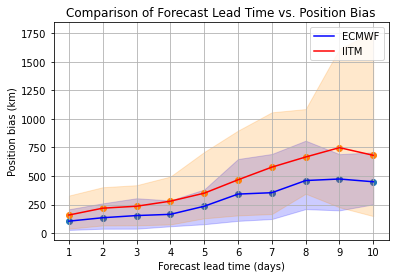

In [47]:
#compare the mean track position bias by day (for  all 102 systems)

fig, ax = plt.subplots()

plt.plot(day_forecast_period_ecmwf, day_track_position_bias_mean_ecmwf, 'b', label = 'ECMWF')
plt.scatter(day_forecast_period_ecmwf, day_track_position_bias_mean_ecmwf)
ax.fill_between(day_forecast_period_ecmwf, day_track_position_bias_10th_ecmwf, day_track_position_bias_90th_ecmwf, alpha=0.2, color='blue')

plt.plot(day_forecast_period_iitm, day_track_position_bias_mean_iitm, 'r', label = 'IITM')
plt.scatter(day_forecast_period_iitm, day_track_position_bias_mean_iitm)
ax.fill_between(day_forecast_period_iitm, day_track_position_bias_10th_iitm, day_track_position_bias_90th_iitm, alpha=0.2, color='darkorange')


ax.set_xticks(np.arange(1, 11, 1))
ax.grid()
ax.set_xlabel("Forecast lead time (days)")
ax.set_ylabel("Position bias (km)")
ax.set_title("Comparison of Forecast Lead Time vs. Position Bias")
plt.legend()

# wilcoxon signed rank test: nonparametric test for independent data

In [46]:
dist_list_of_lists_ecmwf[40]

[200.91808629729175, 347.9652991595213, 909.4083937071761, 360.81950424577536]

In [47]:
#track_position_bias_dist_ecmwf

(array([16., 21., 17.,  9., 10.,  4.,  3.,  0.,  0.,  1.]),
 array([ 13.18109741,  88.75514309, 164.32918877, 239.90323445,
        315.47728012, 391.0513258 , 466.62537148, 542.19941716,
        617.77346284, 693.34750852, 768.92155419]),
 <BarContainer object of 10 artists>)

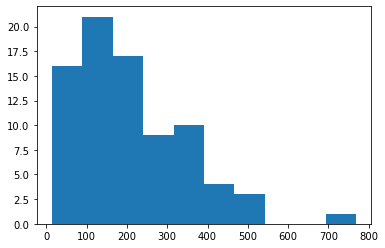

In [48]:
plt.hist(dist_list_of_lists_iitm[4])

In [49]:
for i in range(10):
    print(len(day_list_of_lists_ecmwf[i]), len(day_list_of_lists_iitm[i]), stats.mannwhitneyu(day_list_of_lists_ecmwf[i], day_list_of_lists_iitm[i]))
    
#THE LENGTHS DON'T HAVE MUCH MEANING BECAUSE THEY COUNT A LOT OF OVERLAPPING SYSTEMS!!!

153 295 MannwhitneyuResult(statistic=15865.0, pvalue=1.2530630238595327e-07)
193 337 MannwhitneyuResult(statistic=20399.0, pvalue=4.5068675617240685e-13)
183 284 MannwhitneyuResult(statistic=17779.0, pvalue=4.101351477143495e-09)
136 207 MannwhitneyuResult(statistic=9098.5, pvalue=1.510638452600448e-08)
112 143 MannwhitneyuResult(statistic=5642.0, pvalue=2.595581682373833e-05)
77 111 MannwhitneyuResult(statistic=3057.0, pvalue=0.00045942930451157635)
58 77 MannwhitneyuResult(statistic=1398.0, pvalue=0.00010392616634937154)
46 44 MannwhitneyuResult(statistic=662.0, pvalue=0.00239328526205274)
35 37 MannwhitneyuResult(statistic=439.0, pvalue=0.009552891769234014)
19 23 MannwhitneyuResult(statistic=188.0, pvalue=0.22419010803229694)


In [50]:
#day_list_of_lists_ecmwf

In [51]:
for i in range(41):
    print(len(dist_list_of_lists_ecmwf[i]), len(dist_list_of_lists_iitm[i]), stats.mannwhitneyu(dist_list_of_lists_ecmwf[i], dist_list_of_lists_iitm[i]))
    
    

31 63 MannwhitneyuResult(statistic=688.0, pvalue=0.01027453000215048)
36 74 MannwhitneyuResult(statistic=1170.0, pvalue=0.15178210737385028)
41 77 MannwhitneyuResult(statistic=1102.5, pvalue=0.0036003450479852933)
45 81 MannwhitneyuResult(statistic=1027.5, pvalue=2.6139484698055375e-05)
48 81 MannwhitneyuResult(statistic=1149.0, pvalue=5.41362926414186e-05)
47 81 MannwhitneyuResult(statistic=1073.5, pvalue=2.062437246560722e-05)
48 88 MannwhitneyuResult(statistic=1490.5, pvalue=0.0023428168793419666)
50 87 MannwhitneyuResult(statistic=1404.0, pvalue=0.000285610357047943)
50 79 MannwhitneyuResult(statistic=1397.0, pvalue=0.0026213443539937643)
49 69 MannwhitneyuResult(statistic=1078.5, pvalue=0.00041941584414275545)
44 71 MannwhitneyuResult(statistic=1168.0, pvalue=0.01177512943859973)
40 65 MannwhitneyuResult(statistic=847.5, pvalue=0.0014290181139569524)
37 55 MannwhitneyuResult(statistic=650.5, pvalue=0.0017592477833344976)
35 51 MannwhitneyuResult(statistic=557.5, pvalue=0.001638813

# Extra old code that I don't want to delete just yet

### cross checking that the mean distance biases look like what they did in the 2D histograms

In [18]:
def trackScatter(lonFor, latFor, lonObs, latObs, xval, yval):
    index = 0
    lonBias = []
    for array in lonObs:
        lonBias.append([])
        obs = np.array(array)
        model = np.array(lonFor[index])
        obs[obs == 9999] = 19998
        lonBias[index] = np.subtract(obs, model)
        index += 1
    
    index = 0
    latBias = []
    for array in latObs:
        latBias.append([])
        obs = np.array(array)
        model = np.array(latFor[index])
        obs[obs == 9999] = 19998
        latBias[index] = np.subtract(obs, model)
        index += 1
    
    scatterLon, scatterLat = [], []
    index = 0
    for array in lonBias:
        if len(array) > 0 and len(latBias[index]) > 0:
            index2 = 0
            for item in array:
                if item >= 9999 or item <= -5000 or latBias[index][index2] >= 9999 or latBias[index][index2] <= -5000:
                    k = 5 #do nothing
                else:
                    scatterLon.append(item)
                    scatterLat.append(latBias[index][index2])
                index2 += 1
        index += 1
    
    '''plt.scatter(scatterLon, scatterLat, s= 4)
    plt.title('Model w.r.t. observation')
    plt.xlabel('Degrees longitude')
    plt.ylabel('Degrees latitude')
    plt.xlim(-xval, xval)
    plt.ylim(-yval, yval)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()'''
    
    return scatterLon, scatterLat

In [19]:
#create arrays representing time bias by DAY
#for vector and angle only
lonForOne, latForOne, lonObsOne, latObsOne = [], [], [], []
lonForTwo, latForTwo, lonObsTwo, latObsTwo = [], [], [], []
lonForThree, latForThree, lonObsThree, latObsThree = [], [], [], []
lonForLarge, latForLarge, lonObsLarge, latObsLarge = [], [], [], []

index = 0
for array in newLonFor_ecmwf:
    lonForOne.append(array[0:5])
    latForOne.append(newLatFor_ecmwf[index][0:5])
    lonObsOne.append(newLonObs_ecmwf[index][0:5])
    latObsOne.append(newLatObs_ecmwf[index][0:5])
    
    lonForTwo.append(array[5:10])
    latForTwo.append(newLatFor_ecmwf[index][5:10])
    lonObsTwo.append(newLonObs_ecmwf[index][5:10])
    latObsTwo.append(newLatObs_ecmwf[index][5:10])
    
    lonForThree.append(array[10:15])
    latForThree.append(newLatFor_ecmwf[index][10:15])
    lonObsThree.append(newLonObs_ecmwf[index][10:15])
    latObsThree.append(newLatObs_ecmwf[index][10:15])
    
    lonForLarge.append(array[15:])
    latForLarge.append(newLatFor_ecmwf[index][15:])
    lonObsLarge.append(newLonObs_ecmwf[index][15:])
    latObsLarge.append(newLatObs_ecmwf[index][15:])
    index += 1

In [20]:
scatterLonOne, scatterLatOne = trackScatter(lonForOne, latForOne, lonObsOne, latObsOne, 15, 15)
scatterLonTwo, scatterLatTwo = trackScatter(lonForTwo, latForTwo, lonObsTwo, latObsTwo, 15, 15)
scatterLonThree, scatterLatThree = trackScatter(lonForThree, latForThree, lonObsThree, latObsThree, 15, 15)
scatterLonLarge, scatterLatLarge = trackScatter(lonForLarge, latForLarge, lonObsLarge, latObsLarge, 15, 15)

np.mean(scatterLonOne), np.mean(scatterLonTwo), np.mean(scatterLonThree), np.mean(scatterLonLarge)

#reference ONLY: this is a much cleaner way to create the scatterLon lists
# scatterLonTwoTest = [np.subtract(obsArr, forArr) for obsArr, forArr in zip(lonObsTwo, lonForTwo)]
# scatterLonTwoTest = [j for sub in scatterLonTwoTest for j in sub]
# scatterLonTwoTest = [x for x in scatterLonTwoTest if abs(x) < 100]

## IITM position bias old code

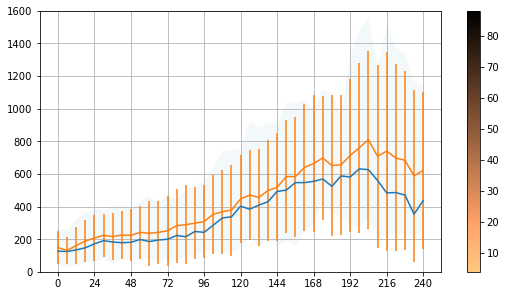

In [128]:
forecast_period_dist_iitm = []
track_position_bias_dist_iitm = []
median_iitm = []
track_position_bias_90th_iitm = []
track_position_bias_10th_iitm = []
track_std_dev_iitm = []
num_systems_iitm = []

clock = 0
a = 6371e3 #earth's radius
for i in range(41):
    
    #include all systems
    lon = np.subtract([arr[i] for arr in newLonFor_iitm if len(arr) > i], [arr[i] for arr in newLonObs2_iitm if len(arr) > i])
    lat = np.subtract([arr[i] for arr in newLatFor_iitm if len(arr) > i], [arr[i] for arr in newLatObs2_iitm if len(arr) > i])
    lat_avg = [(arrFor[i] + arrObs[i])/2 for arrFor, arrObs in zip(newLatFor_iitm, newLatObs2_iitm) if len(arrFor) > i and len(arrObs) > i]
    
    #include only the depressions
    #lon = np.subtract([arr[i] for arr in newLonFor_iitm if len(arr) > i and newLonFor_iitm.index(arr) in depressionsIndicesFor_iitm], [arr[i] for arr in newLonObs2_iitm if len(arr) > i and newLonObs2_iitm.index(arr) in depressionsIndicesFor_iitm])
    #lat = np.subtract([arr[i] for arr in newLatFor_iitm if len(arr) > i and newLatFor_iitm.index(arr) in depressionsIndicesFor_iitm], [arr[i] for arr in newLatObs2_iitm if len(arr) > i and newLatObs2_iitm.index(arr) in depressionsIndicesFor_iitm])
    #lat_avg = [(arrFor[i] + arrObs[i])/2 for arrFor, arrObs in zip(newLatFor_iitm, newLatObs2_iitm) if len(arrFor) > i and len(arrObs) > i and newLatFor_iitm.index(arrFor) in depressionsIndicesFor_iitm]

    forecast_period_dist_iitm.append(clock)
    #bias_lon = np.mean([elem for elem in lon if abs(elem) < 500])
    #bias_lat = np.mean([elem for elem in lat if abs(elem) < 500])
    #if abs(bias) > 10:
    #    print(bias, i)
    #track_position_bias_dist_iitm.append(math.sqrt(bias_lon**2 + bias_lat**2))
    
    #dist_list = [math.sqrt(x**2 + y**2) for x,y in zip(lon, lat) if abs(x) < 500 and abs(y) < 500]
    dist_list = [math.sqrt((a*(x*math.pi/180)*math.cos(z*math.pi/180))**2 + (a*y*math.pi/180)**2) for x,y,z in zip(lon, lat, lat_avg) if abs(x) < 500 and abs(y) < 500]
    dist_list = [x/1000 for x in dist_list]
    
    num_systems_iitm.append(len(dist_list))
    track_position_bias_dist_iitm.append(np.mean(dist_list))
    median_iitm.append(np.median(dist_list))
    track_position_bias_10th_iitm.append(np.percentile(dist_list, 10))
    track_position_bias_90th_iitm.append(np.percentile(dist_list, 90))
    track_std_dev_iitm.append(np.std(dist_list))
    clock += 6
    
#plt.plot(forecast_period_dist_iitm, track_position_bias_dist_iitm, 'bo')
#plt.plot(forecast_period_dist_iitm, track_position_bias_dist_iitm)
#plt.plot(forecast_period_dist_iitm, track_position_bias_dist_iitm_2, 'r')

fig, ax = plt.subplots(figsize=(9,4.8))
#points = ax.scatter(forecast_period_dist_iitm, track_position_bias_dist_iitm, c=num_systems_iitm, cmap = 'copper_r')
plt.colorbar(points)

ax.plot(forecast_period_dist_iitm, median_iitm, '-')

#ax.plot(forecast_period_dist_iitm, track_position_bias_dist_iitm_2, '-')
ax.errorbar(forecast_period_dist_iitm, track_position_bias_dist_iitm, yerr = track_std_dev_iitm)
ax.fill_between(forecast_period_dist_iitm, track_position_bias_10th_iitm, track_position_bias_90th_iitm, alpha=0.05)
ax.set_ylim([0, 1600])
#ax.set_xlim([0, 250])
ax.set_xticks(np.arange(0, 250, 24))
ax.grid()

## Comparing distribution of ecmwf / iitm points on a map to make sure it looks okay

In [36]:
#plot like hour 140 on a map
i = 24

# ECMWF
w = [[arr1[i], arr2[i]] for arr1, arr2 in zip(newLonFor_ecmwf, newLonObs2_ecmwf) if (len(arr1) > 22 and len(arr2) > 22 and abs(arr1[i]) < 500 
                                                                                     and abs(arr2[i]) < 500)]

x = [[arr1[i], arr2[i]] for arr1, arr2 in zip(newLatFor_ecmwf, newLatObs2_ecmwf) if (len(arr1) > 22 and len(arr2) > 22 and abs(arr1[i]) < 500 
                                                                                     and abs(arr2[i]) < 500)]

# IITM
y = [[arr1[i], arr2[i]] for arr1, arr2 in zip(newLonFor_iitm, newLonObs2_iitm) if (len(arr1) > 22 and len(arr2) > 22 and abs(arr1[i]) < 500 
                                                                                   and abs(arr2[i]) < 500)]

z = [[arr1[i], arr2[i]] for arr1, arr2 in zip(newLatFor_iitm, newLatObs2_iitm) if (len(arr1) > 22 and len(arr2) > 22 and abs(arr1[i]) < 500 
                                                                                   and abs(arr2[i]) < 500)]


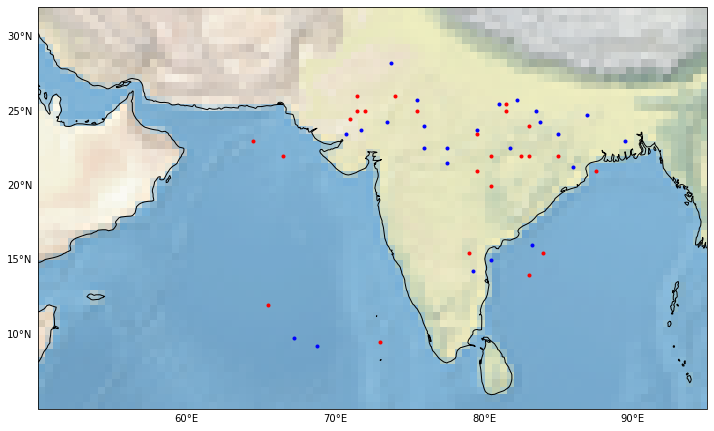

In [38]:
#just plotting the points from list 'w' (for ECMWF) above to get a sense of the # of points and their spread

fig = plt.figure(figsize=[12, 12])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([50, 95, 5, 30])
#ax.set_extent([65, 80, 10, 25])
ax.stock_img()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False

index = 0
for elem in w:
    plt.plot(elem[0], x[index][0], color='red', marker='.')
    plt.plot(elem[1], x[index][1], color='blue', marker='.')
    index += 1
    

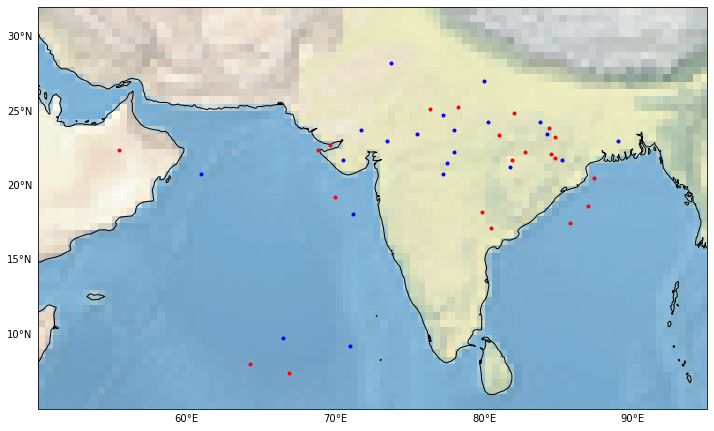

In [39]:
#same as above but for list 'y' (for IITM)

fig = plt.figure(figsize=[12, 12])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([50, 95, 5, 30])
#ax.set_extent([65, 80, 10, 25])
ax.stock_img()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False

index = 0
for elem in y:
    plt.plot(elem[0], z[index][0], color='red', marker='.')
    plt.plot(elem[1], z[index][1], color='blue', marker='.')
    index += 1

## another version of the dual comparison plot

Text(0.5, 1.0, 'Forecast Lead Time vs. Position Bias, IITM')

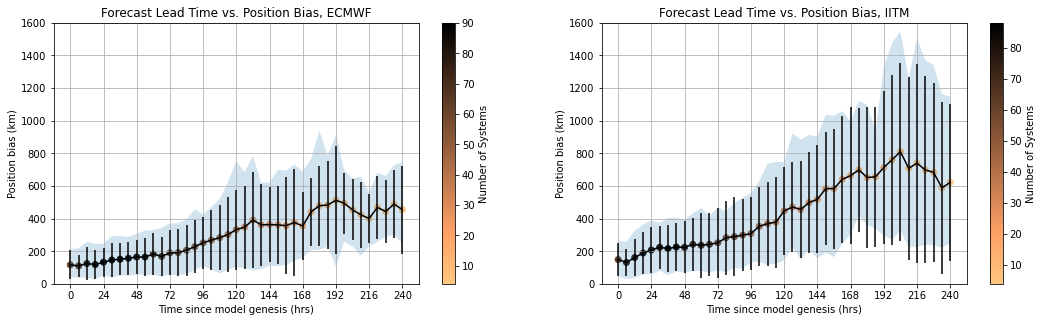

In [160]:
#fig, ax = plt.subplots(figsize=(9,4.8))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4.8))

points = ax1.scatter(forecast_period_ecmwf, track_position_bias_mean_ecmwf, c=num_systems_ecmwf, cmap = 'copper_r')
plt.colorbar(points, ax=ax1).set_label("Number of Systems")
ax1.errorbar(forecast_period_ecmwf, track_position_bias_mean_ecmwf, yerr = track_position_bias_stddev_ecmwf, color='black')
ax1.fill_between(forecast_period_ecmwf, track_position_bias_10th_ecmwf, track_position_bias_90th_ecmwf, alpha=0.2)
ax1.set_ylim([0, 1600])
ax1.set_xticks(np.arange(0, 250, 24))
ax1.grid()
ax1.set_xlabel("Time since model genesis (hrs)")
ax1.set_ylabel("Position bias (km)")
ax1.set_title("Forecast Lead Time vs. Position Bias, ECMWF")


points2 = ax2.scatter(forecast_period_iitm, track_position_bias_mean_iitm, c=num_systems_iitm, cmap = 'copper_r')
plt.colorbar(points2, ax=ax2).set_label("Number of Systems")
ax2.errorbar(forecast_period_iitm, track_position_bias_mean_iitm, yerr = track_position_bias_stddev_iitm, color='black')
ax2.fill_between(forecast_period_iitm, track_position_bias_10th_iitm, track_position_bias_90th_iitm, alpha=0.2)
ax2.set_ylim([0, 1600])
ax2.set_xticks(np.arange(0, 250, 24))
ax2.grid()
ax2.set_xlabel("Time since model genesis (hrs)")
ax2.set_ylabel("Position bias (km)")
ax2.set_title("Forecast Lead Time vs. Position Bias, IITM")
